In [1]:
from itertools import groupby
from json import load
import pandas as pd
import scanpy as sc
import numpy as np
import sys
import tests.loadScanpy as loadScanpy
import modules.classifyClusters.classifyClusters as classify
import os
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

####################################################################################################
# Global Settings 
####################################################################################################
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_columns = sys.maxsize
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

inputData = "./output/savedData.h5ad" # ./dataSaveOriginal/rawDataset5000.h5ad
results_file = './output/savedData.h5ad'
outputDirectory = "./outputPDFs/"


In [2]:
adata = sc.read("./dataSaveOriginal/rawDataset.h5ad")
adata.var_names_make_unique()
adata.X = adata.X.astype('float64')

In [5]:
print(adata.raw.X)

  (0, 14)	1.0
  (0, 16)	1.0
  (0, 29)	1.0
  (0, 32)	1.0
  (0, 36)	1.0
  (0, 44)	2.0
  (0, 45)	1.0
  (0, 53)	1.0
  (0, 59)	3.0
  (0, 61)	1.0
  (0, 62)	3.0
  (0, 68)	1.0
  (0, 73)	1.0
  (0, 75)	1.0
  (0, 77)	1.0
  (0, 82)	1.0
  (0, 86)	2.0
  (0, 94)	2.0
  (0, 97)	1.0
  (0, 105)	1.0
  (0, 109)	1.0
  (0, 146)	1.0
  (0, 170)	5.0
  (0, 187)	1.0
  (0, 190)	1.0
  :	:
  (87822, 36410)	2.0
  (87822, 36423)	2.0
  (87822, 36429)	3.0
  (87822, 36433)	2.0
  (87822, 36443)	2.0
  (87822, 36450)	2.0
  (87822, 36452)	2.0
  (87822, 36468)	3.0
  (87822, 36470)	1.0
  (87822, 36492)	3.0
  (87822, 36500)	4.0
  (87822, 36513)	1.0
  (87822, 36519)	2.0
  (87822, 36559)	42.0
  (87822, 36560)	36.0
  (87822, 36561)	73.0
  (87822, 36562)	88.0
  (87822, 36564)	115.0
  (87822, 36565)	70.0
  (87822, 36566)	42.0
  (87822, 36567)	3.0
  (87822, 36568)	59.0
  (87822, 36569)	10.0
  (87822, 36570)	1.0
  (87822, 36571)	71.0


In [39]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Mark Ribosomal Genes
riboURL = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
riboGenes = pd.read_table(riboURL, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(riboGenes[0].values)

# Calculate QC Metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', "ribo"], percent_top=None, log1p=False, inplace=True)

# Get Top 50 Genes
percentageList = []
print("Calculating Percentatge of Top 50 Genes")
for row in adata.X:
    firstRow = np.sort(row.toarray()[0])
    sum50 = firstRow[-50:]
    percentatge = (sum(sum50)/sum(firstRow))*100
    percentageList.append(percentatge)
adata.obs["percentageTop50"] = percentageList
adata = adata[adata.obs.n_genes_by_counts < 7000, :]

Calculating Percentatge of Top 50 Genes


In [40]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
adata.raw = adata

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40) # n_neighbors=15 is default
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


  (0, 3)	1.8190315
  (0, 6)	10.862102
  (0, 8)	0.5791029
  (0, 14)	49.251083
  (0, 16)	54.62014
  (0, 17)	9.415216
  (0, 18)	4.572126
  (0, 19)	23.77225
  (0, 20)	21.804953
  (0, 21)	5.057944
  (0, 23)	7.2038527
  (0, 24)	176.87253
  (0, 25)	30.04018
  (0, 28)	27.520996
  (0, 29)	705.04175
  (0, 30)	54.7713
  (0, 31)	1.1140242
  (0, 32)	96.50588
  (0, 36)	135.99036
  (0, 37)	28.302595
  (0, 38)	1.9846618
  (0, 41)	3.2175145
  (0, 44)	145.14824
  (0, 45)	115.082535
  (0, 46)	8.292064
  :	:
  (0, 36515)	3.1534855
  (0, 36516)	84.34925
  (0, 36517)	7.1384373
  (0, 36518)	47.004387
  (0, 36519)	162.88525
  (0, 36556)	0.79937035
  (0, 36559)	2189.555
  (0, 36560)	1749.1998
  (0, 36561)	3056.99
  (0, 36562)	2926.6006
  (0, 36563)	129.21466
  (0, 36564)	3033.3325
  (0, 36565)	3017.4521
  (0, 36566)	1926.3225
  (0, 36567)	255.94197
  (0, 36568)	2587.944
  (0, 36569)	1300.4946
  (0, 36570)	242.58379
  (0, 36571)	2633.3308
  (0, 36575)	95.4657
  (0, 36576)	1.5422544
  (0, 36580)	1.9789209
  (0, 

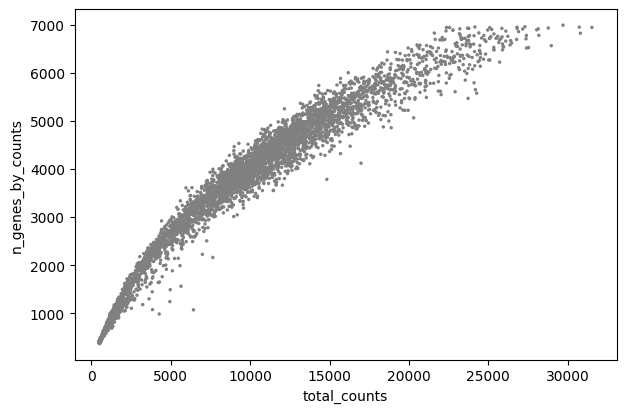

<AxesSubplot: ylabel='id'>

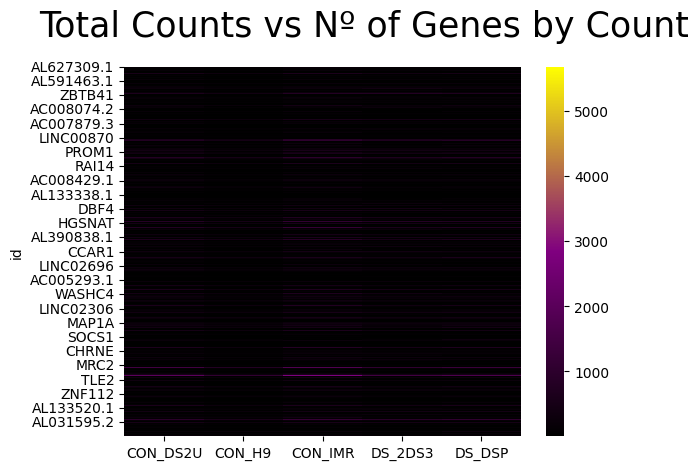

In [55]:
def getColSample(string):
    subset =  adata[adata.obs["sample"] == string]
    returnArray = [sum(x) for x in zip(*subset.X)]
    print(returnArray[0])
    return returnArray[0].toarray()[0]

rows = adata.var["features"].values

# CON_DS2U CON_H9 CON_IMR CON_ihtc DS_2DS3 DS_DS1 DS_DSP

df = pd.DataFrame(rows, columns=['id'])
df["CON_DS2U"] = getColSample("CON_DS2U")
df["CON_H9"] = getColSample("CON_H9")
df["CON_IMR"] = getColSample("CON_IMR")
df["DS_2DS3"] = getColSample("DS_2DS3")
df["DS_DSP"] = getColSample("DS_DSP")
df = df.set_index('id')
df = df.loc[(df['CON_DS2U'] > 0) & (df['CON_H9'] > 0) & (df['CON_IMR'] > 0) & (df['DS_2DS3'] > 0) & (df['DS_DSP'] > 0)]

scatterPlots = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
plt.suptitle("Total Counts vs Nº of Genes by Count", y=1, fontsize=25)
sns.heatmap(df, cmap=sns.blend_palette(["black", "purple", "yellow"], as_cmap=True))

In [53]:
df = df.loc[(df['CON_DS2U'] > 0) & (df['CON_H9'] > 0) & (df['CON_IMR'] > 0) & (df['DS_2DS3'] > 0) & (df['DS_DSP'] > 0)]
df

,CON_DS2U,CON_H9,CON_IMR,DS_2DS3,DS_DSP
id,,,,,
AL627309.1,1.819031,1.355157,3.437437,4.733307,1.706820
AL627309.5,10.862102,10.772249,11.334666,8.988579,3.778477
LINC01409,49.251083,44.305588,71.768135,68.770836,53.308231
LINC01128,54.620140,38.190456,64.620506,67.963684,54.616837
LINC00115,9.415216,6.060261,12.101449,9.459598,7.123745
...,...,...,...,...,...
MT-ND6,242.583786,156.712738,416.925079,150.635132,255.972565
MT-CYB,2633.330811,1364.260376,2642.031738,1811.353638,2529.282715
AC011043.1,95.465698,76.136848,266.596954,100.392624,114.241890
